# Initialization

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass
import pickle
import time
import os, os.path
import sys

In [4]:
IN_COLAB = 'google.colab' in sys.modules

path_mesh    = None
path_samples = None
folder_path  = None
output_path  = None

if IN_COLAB:
    from google.colab import drive
    drive.mount('/gdrive', force_remount=False)

    folder_path = '/gdrive/My Drive/Colab Notebooks/shape_test/'
    output_path = folder_path

    %pip install trimesh
    %pip install rtree
    %pip install scikit-image

    !wget -q https://raw.githubusercontent.com/TheodorSergeev/implicit-template-deformation-for-3d-shapes/main/src/generate_sdf.py
    !wget -q https://raw.githubusercontent.com/TheodorSergeev/implicit-template-deformation-for-3d-shapes/main/src/generator_sdf.py
    !wget -q https://raw.githubusercontent.com/TheodorSergeev/implicit-template-deformation-for-3d-shapes/main/src/mesh.py
    !wget -q https://raw.githubusercontent.com/TheodorSergeev/implicit-template-deformation-for-3d-shapes/main/src/sdf.py
    
    # from src.generate_sdf import *    # issue: igl only available via conda
    from generator_sdf import *
    from mesh import *
    from sdf import *

else:
    folder_path = './data/'
    output_path = './generated_data/'
    
    # from src.generate_sdf import *    # issue: igl only available via conda
    from src.generator_sdf import *
    from src.mesh import *
    from src.sdf import *

    
path_mesh    = folder_path + 'mesh.obj'
path_samples = folder_path + 'samples.npz'

Mounted at /gdrive
     |████████████████████████████████| 642 kB 5.5 MB/s 
     |████████████████████████████████| 994 kB 5.2 MB/s 


In [5]:
import trimesh

cuda = torch.device('cuda')
mesh = trimesh.load(path_mesh)

## Losses

In [6]:
# for sdf

def apply_curriculum_l1_loss(pred_sdf_list, sdf_gt, loss_l1_soft, num_sdf_samples):
    soft_l1_eps_list = [2.5e-2, 1e-2, 2.5e-3, 0]
    soft_l1_lamb_list = [0, 0.1, 0.2, 0.5]
    sdf_loss = []

    pred_sdf_list_len = len(pred_sdf_list)

    for k in range(pred_sdf_list_len):
        eps = soft_l1_eps_list[k]
        lamb = soft_l1_lamb_list[k]
        l = loss_l1_soft(pred_sdf_list[k], sdf_gt, eps=eps, lamb=lamb) / num_sdf_samples
    
        # l = loss_l1(pred_sdf_list[k], sdf_gt[i].cuda()) / num_sdf_samples
        sdf_loss.append(l)
    
    sdf_loss = sum(sdf_loss) / len(sdf_loss)
    return sdf_loss


class SoftL1Loss(nn.Module):
    def __init__(self, reduction=None):
        super(SoftL1Loss, self).__init__()
        self.reduction = reduction

    def forward(self, input, target, eps=0.0, lamb=0.0):
        ret = torch.abs(input - target) - eps
        ret = torch.clamp(ret, min=0.0, max=100.0)
        ret = ret * (1 + lamb * torch.sign(target) * torch.sign(target-input))
        if self.reduction is None or self.reduction == "mean":
            return torch.mean(ret)
        else:
            return torch.sum(ret)


loss_l1 = torch.nn.L1Loss(reduction='mean')
loss_l1_soft = SoftL1Loss(reduction='sum')

In [7]:
# for warper (partly)

class HuberFunc(nn.Module):
    def __init__(self, reduction=None):
        super(HuberFunc, self).__init__()
        self.reduction = reduction

    def forward(self, x, delta):
        n = torch.abs(x)
        cond = n < delta
        l = torch.where(cond, 0.5 * n ** 2, n*delta - 0.5 * delta**2)
        if self.reduction is None or self.reduction == "mean":
            return torch.mean(l)
        else:
            return torch.sum(l)

huber_fn = HuberFunc(reduction="sum")

def apply_pointwise_reg(warped_xyz_list, xyz, huber_fn, num_sdf_samples):
    pw_loss = []
    for k in range(len(warped_xyz_list)):
        dist = torch.norm(warped_xyz_list[k] - xyz, dim=-1)
        pw_loss.append(huber_fn(dist, delta=0.25) / num_sdf_samples)
        # pw_loss.append(torch.sum((warped_xyz_list[k] - xyz_) ** 2) / num_sdf_samples)
    
    pw_loss = sum(pw_loss) / len(pw_loss)
    return pw_loss

# Learning general template

In [ ]:
def learn_general_template(model, conf):
    loss_arr = []

    optimizer = torch.optim.Adam(model.parameters(), lr=conf.learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor=conf.sch_factor, patience=conf.sch_patience, verbose=True
    )

    for epoch in range(conf.epoch_num):
        optimizer.zero_grad()

        xyz, true_sdf = load_samples_from_file(path_samples, conf.num_sdf_samples)

        xyz = torch.Tensor(xyz).cuda()
        true_sdf = torch.Tensor(true_sdf).cuda()

        pred_sdf = model(xyz)

        pred_sdf_list = [pred_sdf]
        true_sdf_list = [true_sdf]

        if conf.enforce_minmax:
            # pred_sdf = pred_sdf * clamp_dist * 1.0
            for k in range(len(pred_sdf_list)):
                pred_sdf_list[k] = torch.clamp(
                    pred_sdf_list[k], -conf.clamp_dist, +conf.clamp_dist
                )
            
        if conf.use_curriculum:
            loss = apply_curriculum_l1_loss(pred_sdf_list, true_sdf_list, 
                                            loss_l1_soft, num_sdf_samples)

        loss = loss_l1(pred_sdf, true_sdf) # / num_sdf_samples
    
        loss.backward()
        optimizer.step()
        
        if conf.use_scheduler:
            scheduler.step(loss)

        loss_arr.append(loss.item())

    return loss_arr


def save_model_and_loss(model, loss_arr, conf):
    if conf.save_model:
        path_model = output_path + conf.model_fname
        torch.save(model, path_model)

        path_loss = output_path + conf.loss_fname

        with open(path_loss, "wb") as fp:
            pickle.dump(loss_arr, fp)
    return


def plot_log_loss(loss_arr):
    plt.plot(np.log(loss_arr))
    plt.ylabel('log loss')
    plt.xlabel('epoch')
    plt.tight_layout()
    plt.show()
    return

In [ ]:
model = SingleShapeDeepSDF(
    hidden_dim  = 256, 
    n_layers    = 8, 
    in_insert   = [], 
    dropout     = 0.0,
    weight_norm = False,
    last_tanh   = True 
).cuda()

@dataclass
class Conf:
    num_sdf_samples = 10000
    epoch_num       = 1000
    learning_rate   = 1e-3

    use_scheduler   = True
    sch_factor      = 0.5
    sch_patience    = 200

    use_curriculum  = False
    enforce_minmax  = False
    clamp_dist      = 1e-3

    save_model  = True
    model_fname = 'model_tmp_overtr.pt'
    loss_fname  = 'loss_tmp_overtr.pt'

conf = Conf()

In [ ]:
loss_arr = learn_general_template(model, Conf())

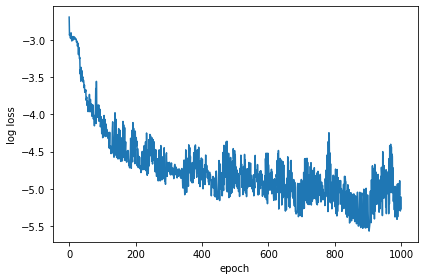

In [ ]:
plot_log_loss(loss_arr)
#save_model_and_loss(model, loss_arr, conf)

In [ ]:
pred_mesh, sdf_grid = create_mesh(model, N=200)

TypeError: meshgrid() got an unexpected keyword argument 'indexing'

In [ ]:
pred_mesh.show()

NameError: name 'pred_mesh' is not defined

# Visualization of training

In [ ]:
def slice_car(mesh, plane_origin, plane_normal):
    slice_3d = mesh.section(plane_origin=plane_origin, 
                            plane_normal=plane_normal)
    slice_2d, to_3d = slice_3d.to_planar()
    return slice_2d


def plot_slices(slice_one, slice_two):
    # adapted from plot_discrete
    # https://github.com/mikedh/trimesh/blob/main/trimesh/path/path.py
    
    axis = plt.gca()
    axis.set_aspect('equal', 'datalim')

    for i, points in enumerate(orig_slice.discrete):
        if i == 0:
            axis.plot(*points.T, 'r-', label='target')
        else:
            axis.plot(*points.T, 'r-')
                    
    for i, points in enumerate(pred_slice.discrete):
        axis.plot(*points.T, 'b--', label='prediction')

    plt.xlabel('x')
    plt.ylabel('z')
    plt.title(f'Slice by plane {str(plane_normal)} at {str(plane_origin)}')
    plt.legend()
    plt.tight_layout()

    return axis


def plot_samples_in_z_slice(n_samples, z_min, z_max):
    xyz, true_sdf = load_samples_from_file(path_samples, n_samples=n_samples)

    xyz_slice = xyz[np.where(xyz[:,2] >= z_min)]
    xyz_slice = xyz_slice[np.where(xyz_slice[:,2] <= z_max)]

    axis = plt.gca()
    axis.set_aspect('equal')

    plt.plot(xyz_slice[:,0], xyz_slice[:,1], '.', label=f"$z\in[{z_min},{z_max}]$")

    plt.suptitle(f'Location of {n_samples} random SDF samples')

    plt.xlim(-1.2, +1.2)
    plt.ylim(-1.2, +1.2)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()
    return xyz_slice.shape[0]


def plot_sdf_grid_slice_vals(sdf_grid, z_index):
    # sdf grid doesn't look too good
    # + we would to compare with true sdf
    # we would need to somehow get a grid from the non-uniform samples
    # idk how to do that at the moment
    plt.imshow(sdf_grid[:,:,z_index].T, origin='top')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Slice at [:,:,{z_index}] of {list(sdf_grid.shape)} sdf grid')
    plt.tight_layout()
    return

In [ ]:
# show samples of sdf

# discs are visible in [0.315, 0.332]
# try 5k, 50k, 500k samples
n_samples = 500 * 1000
slice_size = plot_samples_in_z_slice(n_samples, 0.315, 0.332)

print(f"# points in the sample = {n_samples}")
print(f"# points in the slice  = {slice_size}")
print(f"Proportion of points in the slice {slice_size / n_samples:.3f}")

In [ ]:
# show slices of learnt model and real model

plane_origin = [0, 0, 0.332]
plane_normal = [0, 0, 1.0]

orig_slice = slice_car(mesh, plane_origin, plane_normal)
pred_slice = slice_car(pred_mesh, plane_origin, plane_normal)

plot_slices(orig_slice, pred_slice)

In [ ]:
plot_sdf_grid_slice_vals(sdf_grid, 100)

# Transformations 3d

In [ ]:
# x = car length
# y = car height
# z = car width

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return (rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return (x, y)

def transform(x, y):
    rho, phi = cart2pol(x, y)
    rho_ = rho * (1. + np.sin(phi * 7) / 15.)
    x_, y_ = pol2cart(rho_, phi)
    return x_, y_

def transform3d(x, y, z, coef, peaks):
    rho, phi = cart2pol(z, y)
    rho_ = rho * (1. + np.sin(phi * peaks) * coef)
    z_, y_ = pol2cart(rho_, phi)
    return x, y_, z_

In [ ]:
real_mesh = trimesh.load(path_mesh)
real_mesh.vertices = [transform3d(x, y, z, 0.025, 9) for (x,y,z) in real_mesh.vertices]
real_mesh.show()

# Learning warping

In [15]:
path_rough = output_path + 'model_rough_overtr.pt'
path_good  = output_path + 'model_good_overtr.pt'

model_rough = torch.load(path_rough)
model_good  = torch.load(path_good )
    
model_rough.eval().cuda()
model_good .eval().cuda()

SingleShapeDeepSDF(
  (fcs): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=3, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (4): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (5): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (6): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
    )
    (7): Sequential(
      (0): Linear(in_features=256, out_features=1, bias=True)
      (1): Tanh()
    )
  )
)

In [16]:
# create and save the meshes that models generate to disk
if not os.path.isfile(output_path + 'mesh_rough_overtr.obj'):
    mesh_rough, sdf_rough = create_mesh(model_rough, 300)
    trimesh.exchange.export.export_mesh(mesh_rough, output_path + 'mesh_rough_overtr.obj')

if not os.path.isfile(output_path + 'mesh_good_overtr.obj'):
    mesh_good , sdf_good  = create_mesh(model_good , 300)
    trimesh.exchange.export.export_mesh(mesh_good , output_path + 'mesh_good_overtr.obj')


# compute sdf in the original xyz (same as the ShapeNet car)
orig_xyz, _ = load_samples_from_file(path_samples, n_samples=525000)

sdf_vals_rough = compute_sdf(model_rough, torch.Tensor(orig_xyz))
sdf_vals_good  = compute_sdf(model_good , torch.Tensor(orig_xyz))

In [23]:
def init_recurrent_weights(self):
    for m in self.modules():
        if type(m) in [nn.GRU, nn.LSTM, nn.RNN]:
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    nn.init.kaiming_normal_(param.data)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(param.data)
                elif 'bias' in name:
                    param.data.fill_(0)


def lstm_forget_gate_init(lstm_layer):
    for name, parameter in lstm_layer.named_parameters():
        if not "bias" in name: continue
        n = parameter.size(0)
        start, end = n // 4, n // 2
        parameter.data[start:end].fill_(1.)


def clip_grad_norm_hook(x, max_norm=10):
    total_norm = x.norm()
    total_norm = total_norm ** (1 / 2.)
    clip_coef = max_norm / (total_norm + 1e-6)
    if clip_coef < 1:
        return x * clip_coef


def init_out_weights(self):
    for m in self.modules():
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.uniform_(param.data, -1e-5, 1e-5)
            elif 'bias' in name:
                nn.init.constant_(param.data, 0)


class Warper(nn.Module):
    def __init__(
            self,
            latent_size,
            hidden_size,
            steps,
    ):
        super(Warper, self).__init__()
        self.n_feature_channels = latent_size + 3
        self.steps = steps
        self.hidden_size = hidden_size
        self.lstm = nn.LSTMCell(input_size=self.n_feature_channels,
                                hidden_size=hidden_size)
        self.lstm.apply(init_recurrent_weights)
        lstm_forget_gate_init(self.lstm)

        self.out_layer_coord_affine = nn.Linear(hidden_size, 6)
        self.out_layer_coord_affine.apply(init_out_weights)

    def forward(self, xyz, code=None, step=1.0):
        if step < 1.0:
            input_bk = input.clone().detach()

        #xyz = input[:, -3:]
        #code = input[:, :-3]
        states = [None]
        warping_param = []

        warped_xyzs = []
        for s in range(self.steps):
            state = self.lstm(xyz, #torch.cat([code, xyz], dim=1), 
                              states[-1])
            if state[0].requires_grad:
                state[0].register_hook(lambda x: x.clamp(min=-10, max=10))
            a = self.out_layer_coord_affine(state[0])
            tmp_xyz = torch.addcmul(a[:, 3:], (1 + a[:, :3]), xyz)

            warping_param.append(a)
            states.append(state)
            if (s+1) % (self.steps // 4) == 0:
                warped_xyzs.append(tmp_xyz)
            xyz = tmp_xyz

        if step < 1.0:
            xyz_ = input_bk[:, -3:]
            xyz = xyz * step + xyz_ * (1 - step)

        return xyz, warping_param, warped_xyzs

In [24]:
warper = Warper(latent_size=0, hidden_size=64, steps=8).cuda()

optimizer = torch.optim.Adam(warper.parameters(), lr=1e-3)

num_sdf_samples = 5000
epoch_num = 100
loss_log = []

pointwise_loss_weight = 0.5

In [32]:
warper.train()

for epoch in range(epoch_num):
    optimizer.zero_grad()

    xyz, true_sdf = load_samples_from_file(path_samples, n_samples=num_sdf_samples)
    true_sdf = compute_sdf(model_rough, torch.Tensor(xyz))

    xyz = torch.Tensor(xyz).cuda()
    true_sdf = torch.Tensor(true_sdf).cuda()

    p_final, warping_param, warped_xyzs = warper(xyz)

    pred_sdf = model_good(p_final)

    batch_loss_sdf = 0.0
    batch_loss_pw = 0.0
    batch_loss_reg = 0.0
    batch_loss_pp = 0.0
    batch_loss = 0.0

    sdf_loss = loss_l1(pred_sdf, true_sdf.cuda()) / num_sdf_samples
    batch_loss_sdf += sdf_loss.item()
    chunk_loss = sdf_loss

    pw_loss = apply_pointwise_reg(warped_xyzs, xyz, huber_fn, num_sdf_samples)
    batch_loss_pw += pw_loss.item()
    chunk_loss = chunk_loss + pw_loss.cuda() * pointwise_loss_weight * max(1.0, 10.0 * (1 - epoch / 100))

    chunk_loss.backward()
    batch_loss += chunk_loss.item()

    optimizer.step()
    
    loss_log.append(chunk_loss.item())

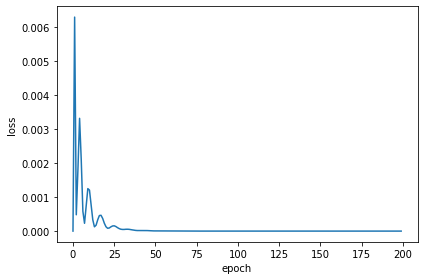

In [33]:
plt.plot(loss_log)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.tight_layout()
plt.show()
#plt.ylim(-1e-1, 10)

In [34]:
def create_mesh2(model, warper, N=256, max_batch=32**3, verbose=False):
    sdf_grid = compute_sdf_grid(model, N=N, max_batch=max_batch, verbose=verbose)
    mesh = convert_sdf_grid_to_mesh(sdf_grid, voxel_size=2. / (N - 1))
    return mesh, sdf_grid

In [35]:
pred_mesh2, sdf_grid2 = create_mesh2(model_rough, warper, N=200)

In [36]:
pred_mesh2.show()